In [284]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence
from signature.signature.stationary_signature import stationary_signature_from_path, G
from signature.signature.expected_signature import expected_signature, expected_stationary_signature
from scipy.optimize import minimize

green = "#5b6c64"
copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[green, copper, "#322B4D", "#28BC9C", "#71074E"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [285]:
%%time
ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: total: 0 ns
Wall time: 1.53 ms


Text(0.5, 1.0, 'Driving Brownian motion W')

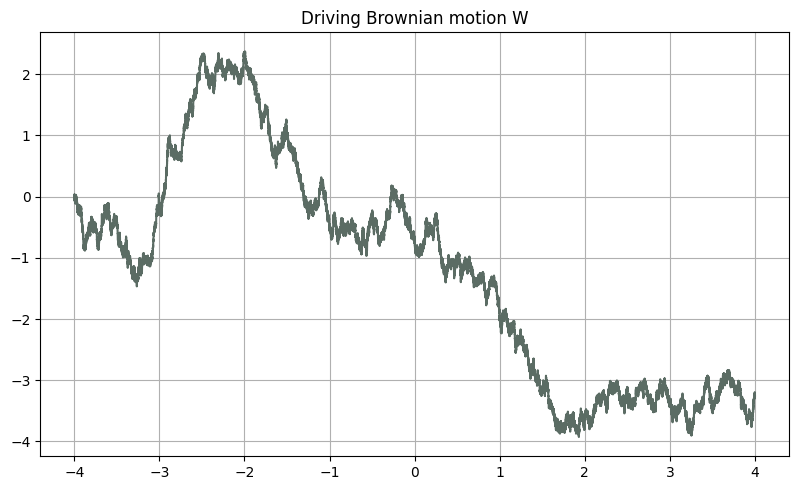

In [405]:
points_per_day = 20
T = 4

t_grid = np.linspace(-T, T, points_per_day * 5 * T * 365 + 1)

rng = np.random.default_rng(seed=42)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])

fig, ax = plt.subplots()

ax.plot(t_grid, W)
ax.set_title("Driving Brownian motion W")


## OU representation

$$
d\sigma_t = \kappa (\theta - \sigma_t) dt + dW_t
$$

In [406]:
kappa = 15
theta = 0
nu = 1

ou = np.zeros_like(W)
ou[0] = theta
dt = np.diff(t_grid)
dW = np.diff(W)
for i in range(ou.size - 1):
    ou[i + 1] = ou[i] + kappa * (theta - ou[i]) * dt[i] + nu * dW[i]

Text(0.5, 1.0, 'OU trajectory')

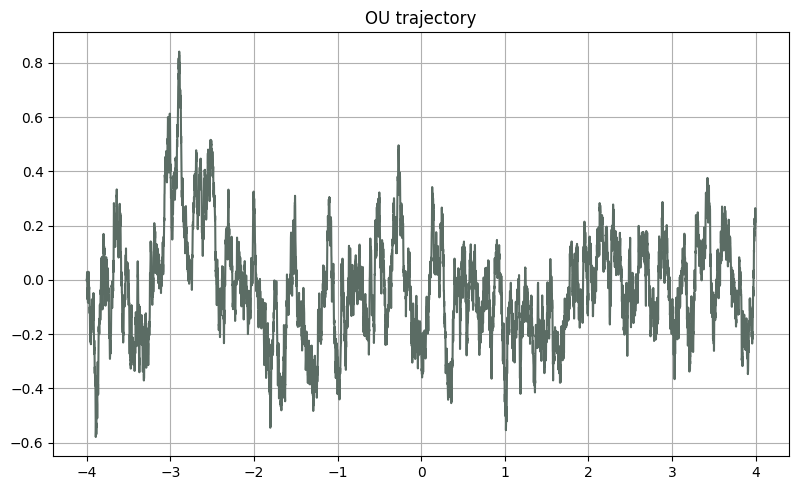

In [407]:
t_daily = t_grid[::points_per_day]
W_daily = W[::points_per_day]
ou_daily = ou[::points_per_day]

fig, ax = plt.subplots()
ax.plot(t_daily, ou_daily)
ax.set_title("OU trajectory")

In [408]:
%%time

path = np.vstack([t_daily, W_daily]).T
path_pos = np.vstack([t_daily[t_daily >= 0], W_daily[t_daily >= 0]]).T

N = 10
W_sig = ta.path_to_sequence(path=path_pos, trunc=N)

CPU times: total: 422 ms
Wall time: 560 ms


In [477]:
%%time

N = 10
lam = 3
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_daily, lam=lam)

CPU times: total: 9.73 s
Wall time: 17.3 s


In [478]:
e0 = ta.from_dict({"": 1}, trunc=N)
e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)
e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)
e221 = ta.from_dict({"221": 1}, trunc=N)

In [292]:
def repr_operator(ell, lam, mu, sigma, x0=0):
    return e0 * x0 + (G(ell) * lam + mu(ell)).tensor_prod_word("1") + (sigma(ell)).tensor_prod_word("2")

mu_ou = lambda ell: ell * (-kappa)
sigma_ou = lambda ell: e0 * 1

In [293]:
l_kappa_iter = e0 * 0
for i in range(N + 1):
    l_kappa_iter = repr_operator(l_kappa_iter, lam, mu_ou, sigma_ou)
ta.print(l_kappa_iter)

1.0*2 + -5.0*21 + -25.0*211 + -375.0*2111 + -9375.0*21111 + -328125.0*211111 + -14765625.0*2111111 + -812109375.0*21111111 + -52787109375.0*211111111 + -3959033203125.0*2111111111


In [294]:
green = "#5b6c64"
copper = "#B56246"

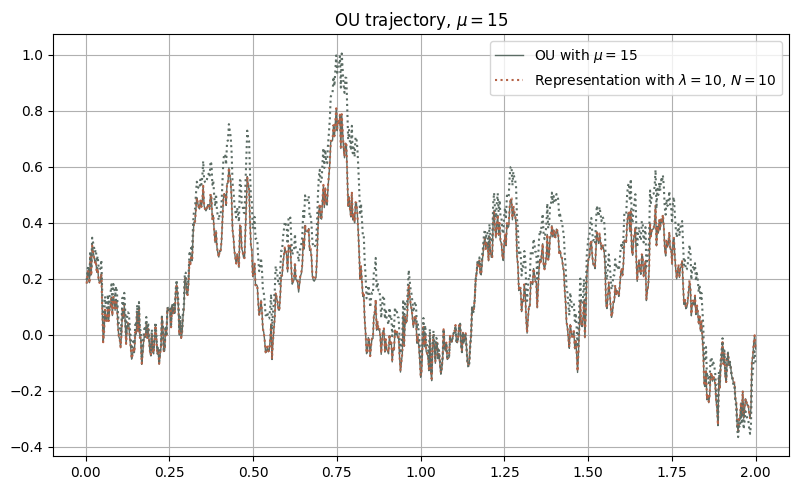

In [296]:
fig, ax = plt.subplots()
idx_start = 0
step = 500

# ax.plot(t_daily[t_daily >= 0][idx_start:idx_start+step], (SigS @ (Ø * theta + _2)).real[idx_start:idx_start+step], "b", lw=1)
ax.plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], color=green, lw=1, label=f"OU with $\mu={kappa}$")
ax.plot(t_daily[t_daily >= 0], (SigS @ (e0 * theta + l_kappa_iter)).real, ":", color=copper, label=f"Representation with $\lambda={lam}$, $N={N}$", lw=1.5)
ax.plot(t_daily[t_daily >= 0], (SigS @ e2).real, ":", lw=1.5)
ax.set_title(f"OU trajectory, $\mu={kappa}$")
ax.legend()

In [297]:
s0 = ou_daily[t_daily >= 0][0]

In [250]:
l_kappa_iter_lam0_dict = {}

for repr_trunc in range(2, 11):
    l_kappa_iter_lam0 = e0 * 0
    for i in range(repr_trunc + 1):
        l_kappa_iter_lam0 = repr_operator(l_kappa_iter_lam0, 0, mu_ou, sigma_ou, x0=s0)
    print(repr_trunc)
    ta.print(l_kappa_iter_lam0)
    l_kappa_iter_lam0_dict[repr_trunc] = l_kappa_iter_lam0

2
0.18466763510915968*∅ + -2.7700145266373952*1 + 1.0*2 + 41.55021789956093*11 + -15.0*21 + 225.0*211
3
0.18466763510915968*∅ + -2.7700145266373952*1 + 1.0*2 + 41.55021789956093*11 + -15.0*21 + -623.2532684934139*111 + 225.0*211 + -3375.0*2111
4
0.18466763510915968*∅ + -2.7700145266373952*1 + 1.0*2 + 41.55021789956093*11 + -15.0*21 + -623.2532684934139*111 + 225.0*211 + 9348.799027401208*1111 + -3375.0*2111 + 50625.0*21111
5
0.18466763510915968*∅ + -2.7700145266373952*1 + 1.0*2 + 41.55021789956093*11 + -15.0*21 + -623.2532684934139*111 + 225.0*211 + 9348.799027401208*1111 + -3375.0*2111 + -140231.98541101813*11111 + 50625.0*21111 + -759375.0*211111
6
0.18466763510915968*∅ + -2.7700145266373952*1 + 1.0*2 + 41.55021789956093*11 + -15.0*21 + -623.2532684934139*111 + 225.0*211 + 9348.799027401208*1111 + -3375.0*2111 + -140231.98541101813*11111 + 50625.0*21111 + 2103479.781165272*111111 + -759375.0*211111 + 11390625.0*2111111
7
0.18466763510915968*∅ + -2.7700145266373952*1 + 1.0*2 + 41.5502

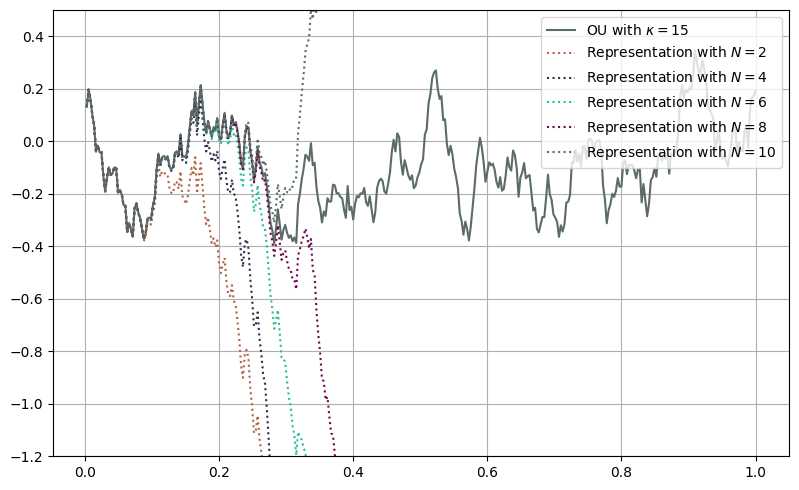

In [85]:
fig, ax = plt.subplots()


plt.plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], label=f"OU with $\kappa={kappa}$")
for k in [2, 4, 6, 8, 10]:
    plt.plot(t_daily[t_daily >= 0], (W_sig @ l_kappa_iter_lam0_dict[k]).real, ":", label=f"Representation with $N={k}$")
plt.ylim([-1.2, 0.5])
plt.legend(loc=1)

fig.savefig("ou_representation_convergence.pdf", format="pdf", transparent=True)

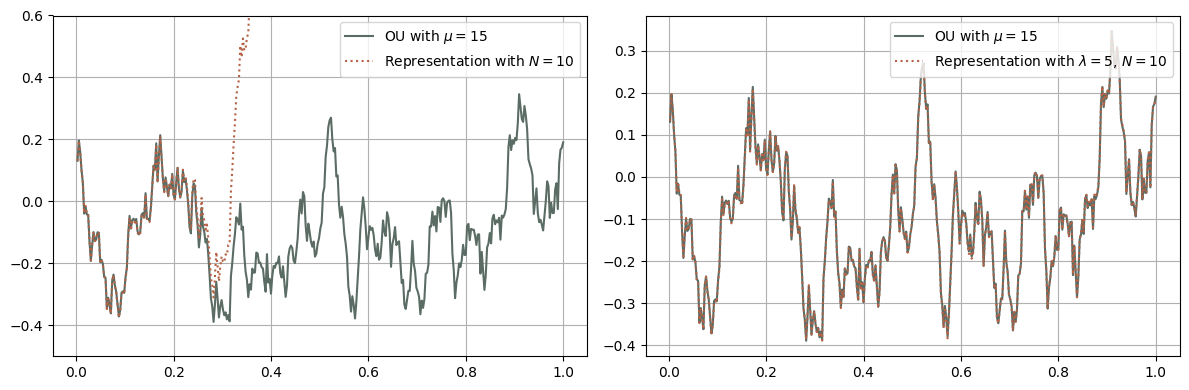

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

idx_start = 0
step = 500

ax[0].plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], color=green, label=f"OU with $\mu={kappa}$")
ax[0].plot(t_daily[t_daily >= 0], (W_sig @ l_kappa_iter_lam0).real, ":", color=copper, label=f"Representation with $N={N}$")
ax[0].set_ylim([-0.5, 0.6])
ax[0].legend(loc=1)

ax[1].plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], color=green, label=f"OU with $\mu={kappa}$")
ax[1].plot(t_daily[t_daily >= 0], (SigS @ (e0 * theta + l_kappa_iter)).real, ":", color=copper, label=f"Representation with $\lambda={lam}$, $N={N}$")
ax[1].legend(loc=1)

fig.tight_layout()
fig.savefig("signature_ou_representation.pdf", format="pdf", transparent=True)

### Langevin dynamics

$$
dX_t = - \mu X_t^p dt + dW_t
$$

In [411]:
e0 = ta.from_dict({"": 1}, trunc=N)
e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)
e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)
e221 = ta.from_dict({"221": 1}, trunc=N)

In [412]:
mu = 50
p = 5

In [413]:
X = np.zeros_like(W)
X[0] = 0
dt = np.diff(t_grid)
dW = np.diff(W)
for i in range(X.size - 1):
    X[i + 1] = X[i] -mu * (X[i]**p) * dt[i] + dW[i]

X_daily = X[::points_per_day]

In [301]:
mu_langevin = lambda l: l.shuffle_pow(p) * (-mu)
sigma_langevin = lambda l: e0 * 1

In [255]:
%%time

N = 10
lam = 30
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_daily, lam=lam)

CPU times: total: 2.61 s
Wall time: 4.27 s


In [94]:
%%time

l_langevin_stat = e0 * 0
for i in range(N + 1):
    l_langevin_stat = repr_operator(l_langevin_stat, lam, mu_langevin, sigma_langevin)
ta.print(l_langevin_stat)
print(not bool(l_langevin_stat - repr_operator(l_langevin_stat, lam, mu_langevin, sigma_langevin)))

1.0*2 + 30.0*21 + 1800.0*211 + 162000.0*2111 + 19440000.0*21111 + 2916000000.0*211111 + -6000.0*222221 + 524880000000.0*2111111 + -180000.0*2122221 + -360000.0*2212221 + -540000.0*2221221 + -720000.0*2222121 + -1980000.0*2222211 + 110224800000000.0*21111111 + -10800000.0*21122221 + -16200000.0*21212221 + -21600000.0*21221221 + -27000000.0*21222121 + -70200000.0*21222211 + -32400000.0*22112221 + -43200000.0*22121221 + -54000000.0*22122121 + -140400000.0*22122211 + -64800000.0*22211221 + -81000000.0*22212121 + -210600000.0*22212211 + -108000000.0*22221121 + -280800000.0*22221211 + -577800000.0*22222111 + 2.6453952e+16*211111111 + -972000000.0*211122221 + -1296000000.0*211212221 + -1620000000.0*211221221 + -1944000000.0*211222121 + -4860000000.0*211222211 + -1944000000.0*212112221 + -2430000000.0*212121221 + -2916000000.0*212122121 + -7290000000.0*212122211 + -3240000000.0*212211221 + -3888000000.0*212212121 + -9720000000.0*212212211 + -4860000000.0*212221121 + -12150000000.0*212221211 + 

In [95]:
%%time

x0 = X_daily[t_daily >= 0][0]
l_langevin = e0 * 0
for i in range(N + 2):
    l_langevin = repr_operator(l_langevin, 0, mu_langevin, sigma_langevin, x0=x0)
ta.print(l_langevin)
print(not bool(l_langevin - repr_operator(l_langevin, lam, mu_langevin, sigma_langevin)))

0.4520515342626837*∅ + -0.9438646960741622*1 + 1.0*2 + 9.853750037019967*11 + -10.439790870455154*21 + -185.1679614172108*111 + 87.19138673507103*121 + 196.1806201539098*211 + -92.37699756938483*221 + 5026.098462070893*1111 + -1456.4157491505912*1121 + -3276.9354355888295*1211 + 578.6379215189532*1221 + -5325.020082831847*2111 + 1543.034457383875*2121 + 3471.8275291137184*2211 + -613.0517688877388*2221 + -178402.8172503438*11111 + 36491.222019766676*11121 + 82105.24954447501*11211 + -8457.2024465218*11221 + 133421.03050977187*12111 + -22552.539857391464*12121 + -50743.21467913079*12211 + 2560.0529039802395*12221 + 189013.12655551013*21111 + -38661.49689838536*21121 + -86988.36802136705*21211 + 8960.185163930837*21221 + -141356.09803472145*22111 + 23893.82710381557*22121 + 53761.11098358502*22211 + -2712.309205576102*22221 + 7822450.031733197*111111 + -1219074.3247798788*111121 + -2742917.2307547275*111211 + 194241.13475973645*111221 + -4457240.499976432*112111 + 517976.3593592971*11212

StatSig RMSE:  0.367508164266606


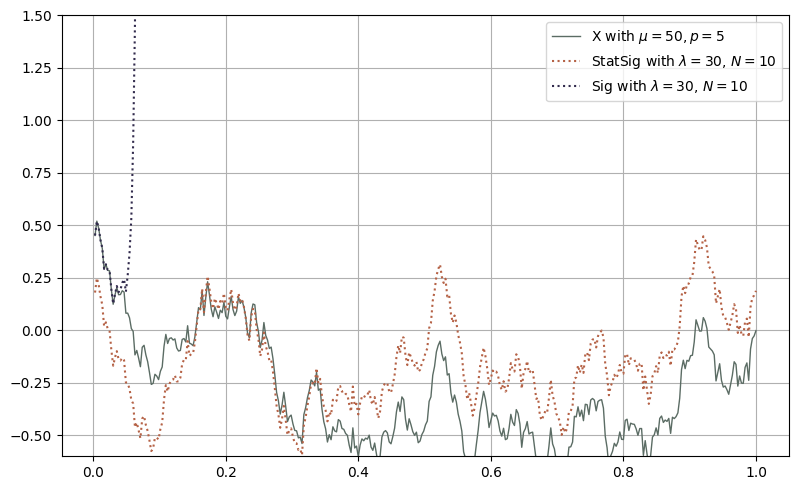

In [96]:
fig, ax = plt.subplots()
idx_start = 0
step = 500

ax.plot(t_daily[t_daily >= 0], X_daily[t_daily >= 0], lw=1, label=f"X with $\mu={mu}, p = {p}$")
ax.plot(t_daily[t_daily >= 0], (SigS @ l_langevin_stat).real, ":", label=f"StatSig with $\lambda={lam}$, $N={N}$")
ax.plot(t_daily[t_daily >= 0], (W_sig @ l_langevin).real, ":", label=f"Sig with $\lambda={lam}$, $N={N}$")
ax.set_ylim([-0.6, 1.5])
ax.legend()

print("StatSig RMSE: ", np.sqrt(np.mean(((SigS @ l_langevin_stat).real - X_daily[t_daily >= 0])**2)))

- Try regression ?

## Regression comparaison

In [600]:
%%time

N = 10
lam = 3
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_daily, lam=lam)

CPU times: total: 12.2 s
Wall time: 13.3 s


In [601]:
OU_lam = (SigS @ e2).real.squeeze()

path_pos = np.vstack([t_daily[t_daily >= 0], OU_lam]).T

N = 10
OU_sig = ta.path_to_sequence(path=path_pos, trunc=N)

t_daily_pos = t_daily[t_daily >= 0]

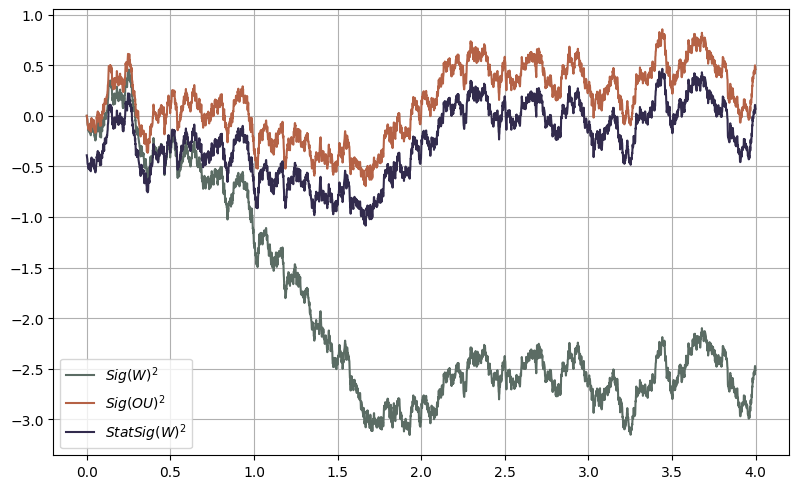

In [602]:
plt.plot(t_daily_pos, (W_sig @ e2).real, label=r"$Sig(W)^2$")
plt.plot(t_daily_pos, (OU_sig @ e2).real, label=r"$Sig(OU)^2$")
plt.plot(t_daily_pos, (SigS @ e2).real, label=r"$StatSig(W)^2$")
plt.legend()

### Signal $S_t = \dfrac{1}{\sqrt{1 + Z_t}}$

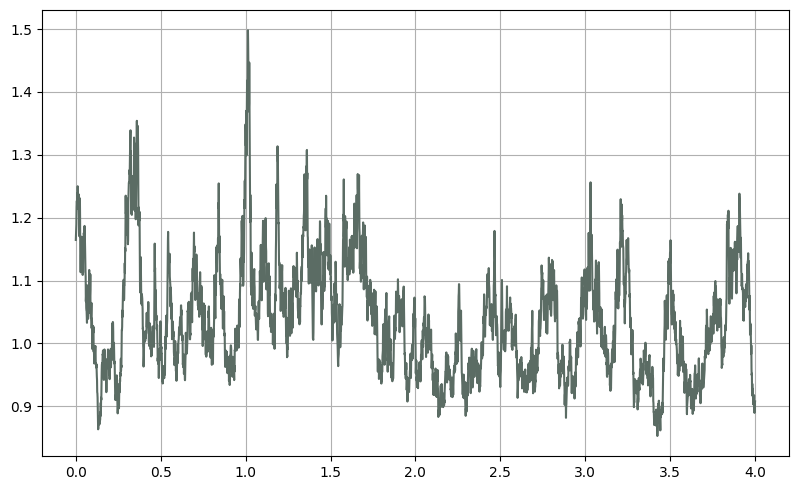

In [603]:
signal = 1 / np.sqrt((1 + ou_daily[t_daily >= 0]))
plt.plot(t_daily_pos, signal)

Mean Squared Error (Sig(W)): 0.014732417156134424
Mean Squared Error (Sig(OU)): 0.00549092815970765
Mean Squared Error (StatSig(W)): 2.8194238556777185e-05


C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


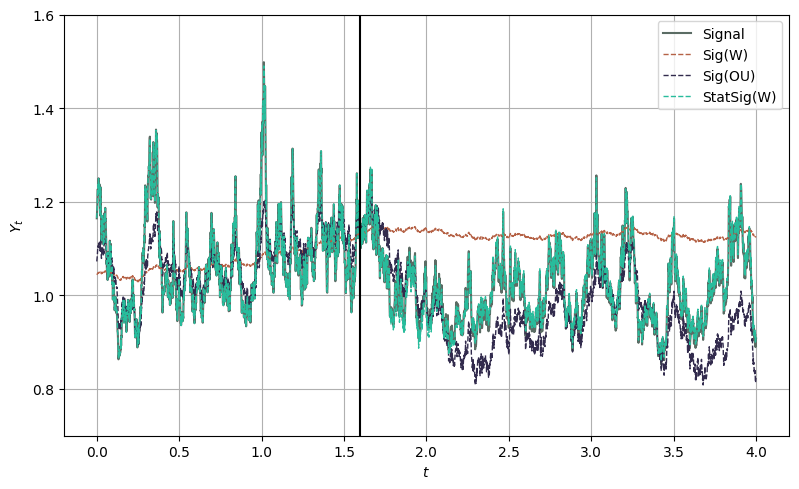

In [604]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

trunc = 6
idx_train = 365 * 4

plt.plot(t_daily_pos, signal, label='Signal')

for label, sig in zip(["Sig(W)", "Sig(OU)", "StatSig(W)"], [W_sig, OU_sig, SigS]):
    alpha = 0 if label == "StatSig(W)" else 0.009
    model = Lasso(alpha=alpha)
    X = sig.array[:ta.alphabet.number_of_elements(trunc)].squeeze().real.T
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    model.fit(X[:idx_train], signal[:idx_train])

    signal_pred = model.predict(X)

    mse = mean_squared_error(signal, signal_pred)
    print(f"Mean Squared Error ({label}): {mse}")
    # Plot results
    plt.plot(t_daily_pos, signal_pred, "--", lw=1, label=label)
    
plt.xlabel("$t$")
plt.ylabel("$Y_t$")
plt.ylim([0.7, 1.6])
plt.vlines(t_daily_pos[idx_train], 0.6, 1.6, color="k")
plt.legend()
plt.show()

## Langevin signal

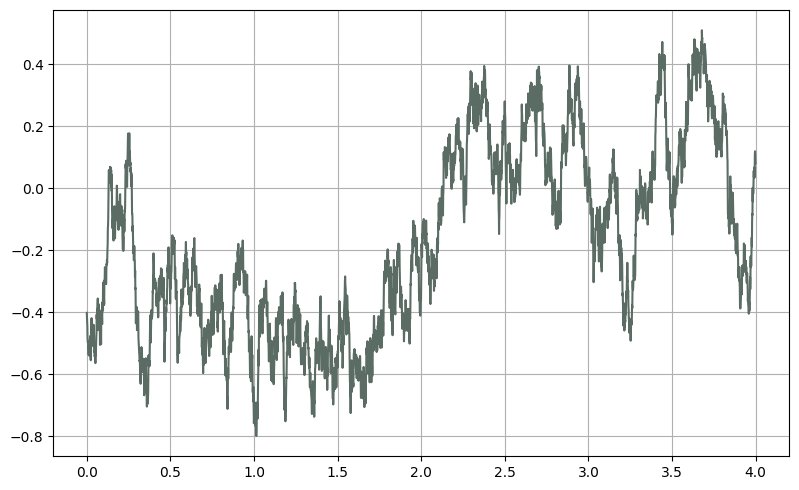

In [605]:
signal = X_daily[t_daily >= 0]
plt.plot(t_daily_pos, signal)

RMSE (Sig(W)): 0.4660353265237076
RMSE (Sig(OU)): 0.10251739166512025
RMSE (StatSig(W)): 0.04870876482456693


C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.221e-02, tolerance: 1.326e-02
  model = cd_fast.enet_coordinate_descent(


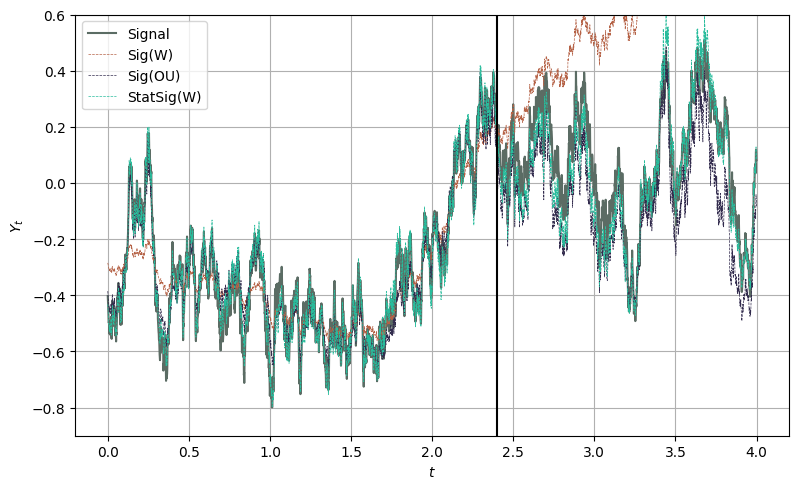

In [606]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.feature_selection import SelectFromModel

trunc = 3
idx_train = 365 * 6

plt.plot(t_daily_pos, signal, label='Signal')

for label, sig in zip(["Sig(W)", "Sig(OU)", "StatSig(W)"], [W_sig, OU_sig, SigS]):
    alpha = 0.00001 if label == "StatSig(W)" else 0.008
    X = sig.array[:ta.alphabet.number_of_elements(trunc)].squeeze().real.T

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    model = Lasso(alpha=alpha)
    model.fit(X[:idx_train], signal[:idx_train])

    signal_pred = model.predict(X)

    rmse = root_mean_squared_error(signal, signal_pred)
    print(f"RMSE ({label}): {rmse}")
    # Plot results
    plt.plot(t_daily_pos, signal_pred, "--", lw=0.5, label=label)
    
plt.xlabel("$t$")
plt.ylabel("$Y_t$")
plt.ylim([-0.9, 0.6])
plt.vlines(t_daily_pos[idx_train], -1, 1., color="k")
plt.legend()
plt.show()

In [607]:
trunc = 3
n_params = 2**(trunc + 1) - 1
eps_sig = 5e-5
eps_sigs = 0

in_sample_T = t_daily_pos[idx_train]
in_sample_idx = (t_daily_pos <= in_sample_T)

def loss_vol_sig(l):
    vol_coef = ta.from_array(array=l, trunc=trunc)
    return np.mean((signal - np.real(Sig @ vol_coef).squeeze())[in_sample_idx]**2) + eps_sig * np.sum(np.abs(l))

def loss_vol_stat_sig(l):
    vol_coef = ta.from_array(array=l, trunc=trunc)
    return np.mean((signal - np.real(SigS @ vol_coef).squeeze())[in_sample_idx]**2) + eps_sigs * np.sum(np.abs(l))

l0 = np.zeros(n_params)

In [608]:
res_stat = minimize(fun=loss_vol_stat_sig, x0=l0)
l_reg_stat = ta.from_array(array=res_stat.x, trunc=trunc*2 + 1)

MSE: 0.07101970544304814


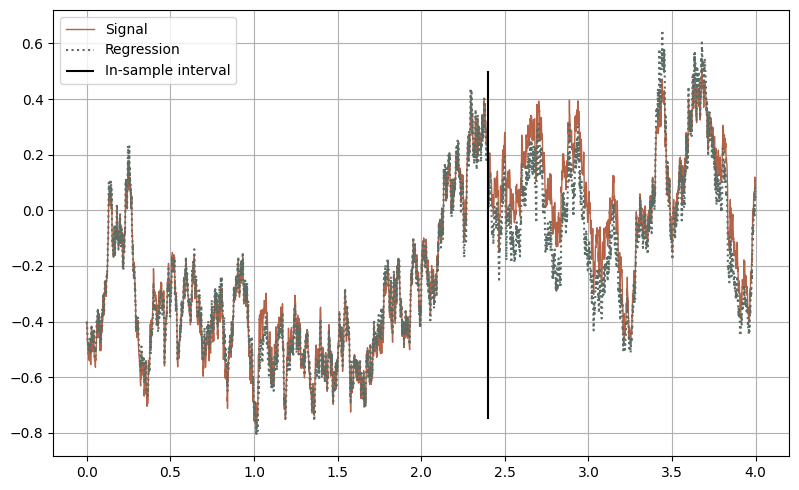

In [609]:
# l_reg = ta.from_array(array=res.x, trunc=trunc*2 + 1)
l_reg_stat = ta.from_array(array=res_stat.x, trunc=trunc*2 + 1)


plt.plot(t_daily_pos, signal, color=copper, lw=1, label="Signal")
plt.plot(t_daily_pos, (SigS @ l_reg_stat).real, ":", color=green, label="Regression")
plt.vlines(x=in_sample_T, ymin=-0.75, ymax=0.5, color="k", label="In-sample interval")
#plt.set_ylim([-1, 1])
#ax[1].set_title("Stationary Signature regression")
plt.legend()

print("MSE:", root_mean_squared_error((SigS @ l_reg_stat).real.squeeze(), signal))